In [5]:
import cobra
import pandas as pd
import re
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
import leakage, utils
import pubchempy as pcp
import seaborn as sns
import time


# Shadow prices
Do the following:
1. Check how shadow prices vary with increasing growth rates
2. Compute "mean" shadow prices
    - for low and high uptake rates?

In [70]:
species = 'e_coli'
model_ec = cobra.io.read_sbml_model('../../models/{0}/momentiJO1366.xml'.format(species))
model = cobra.io.read_sbml_model('../../models/{0}/iJO1366.xml'.format(species))


# Plot shadow prices for a few selected metabolites and with and without enzyme-constraints

In [75]:
glc_uptake_rates = np.arange(2, 13, 0.5)

mets = ['pyr_c', 'ac_c', 'ala__L_c', 'glu__L_c', 'pep_c', 'ura_c', 'g6p_c']


In [76]:
# for b in model.boundary:
sp_list = []
growth_rates = []
boundary_lst = []
uptake = []

for i, g in enumerate(glc_uptake_rates):
    model.reactions.EX_glc__D_e.lower_bound = -g
    solution = model.optimize()
    # print(model.summary())
    if solution.status == 'optimal':
        sp_list.append(solution.shadow_prices[mets])
        growth_rates.append(solution.objective_value)
        # boundary_lst.append(b.id)
        uptake.append(g)
        # print(solution.fluxes['ATPS4rpp_TG_forward'])
df = pd.DataFrame(sp_list)
df.index = glc_uptake_rates


In [77]:
# for b in model.boundary:
sp_list = []
growth_rates = []
boundary_lst = []
uptake = []

for i, g in enumerate(glc_uptake_rates):
    model_ec.reactions.EX_glc__D_e.lower_bound = -g
    solution = model_ec.optimize()
    # print(model.summary())
    if solution.status == 'optimal':
        sp_list.append(solution.shadow_prices[mets])
        growth_rates.append(solution.objective_value)
        # boundary_lst.append(b.id)
        uptake.append(g)
        # print(solution.fluxes['ATPS4rpp_TG_forward'])
df_ec = pd.DataFrame(sp_list)
df_ec.index = glc_uptake_rates


Text(0.5, 1.0, 'moment-iJO1366')

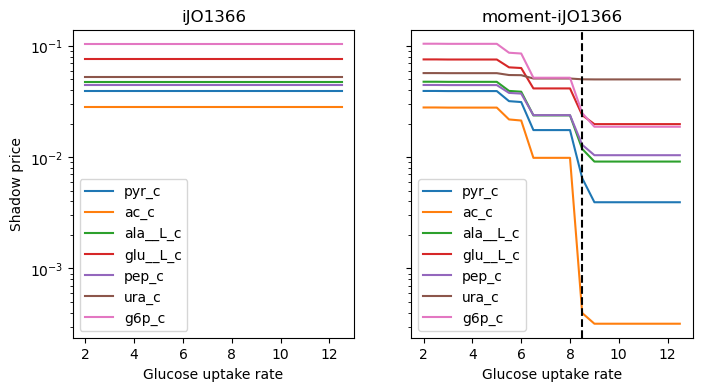

In [87]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize = (8, 4))
(df[mets]*-1).plot(ax=ax1)
ax1.set_yscale('log')
ax1.set_xlabel('Glucose uptake rate')
# plt.ylabel('')

(df_ec[mets]*-1).plot(ax=ax2)
ax2.set_yscale('log')
ax2.axvline(8.5, c = 'k', ls = '--', label = 'Threshold for overflow')
ax2.set_xlabel('Glucose uptake rate')
ax1.set_ylabel('Shadow price')

ax1.set_title('iJO1366')
ax2.set_title('moment-iJO1366')

## Check whether any normalization makes sense
tl;dr: - it is not

<AxesSubplot:>

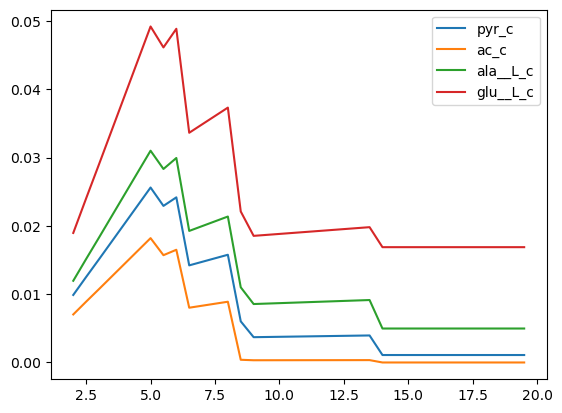

In [42]:
mets = ['pyr_c', 'ac_c', 'ala__L_c', 'glu__L_c']
(df[mets].T*-1*(growth_rates/np.max(growth_rates))).T.plot()
# plt.yscale('log')

<AxesSubplot:>

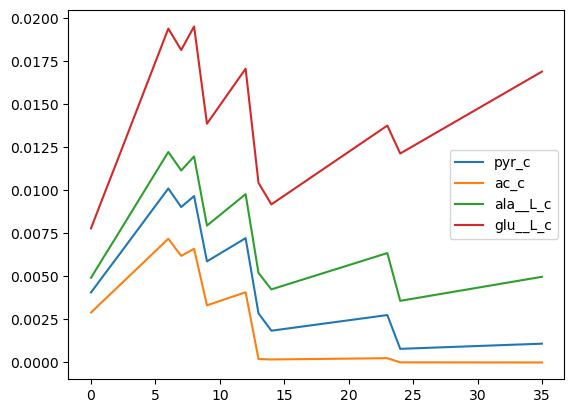

In [10]:
mets = ['pyr_c', 'ac_c', 'ala__L_c', 'glu__L_c']
(df[mets].T*-1*(glc_uptake_rates/np.max(glc_uptake_rates))).T.plot()
# plt.yscale('log')

# Calculate shadow price for measured metabolites

In [88]:
species = 'e_coli'
model = cobra.io.read_sbml_model('../../models/{0}/momentiJO1366.xml'.format(species))
# model = cobra.io.read_sbml_model('../../models/{0}/iJO1366.xml'.format(species))


In [65]:
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)

In [66]:
mets = []
for i, row in mapping_df.iterrows():
    
    key = row['Ecoli metabolite']
    # print(i, key)
    try:
        all_keys = key.split(',')
    except AttributeError:
        continue
    else:
        if len(all_keys):
            for m in all_keys:
                mets.append("{0}_c".format(m.strip()))
                
mets = np.unique(mets)

In [67]:
mets

array(['2pg_c', '3pg_c', 'ac_c', 'acon_C_c', 'akg_c', 'ala__L_c',
       'arg__L_c', 'asn__L_c', 'asp__L_c', 'cit_c', 'dhap_c', 'e4p_c',
       'etoh_c', 'f6p_c', 'fdp_c', 'fum_c', 'g3p_c', 'g6p_c', 'gln__L_c',
       'glu__L_c', 'gly_c', 'his__L_c', 'hom__L_c', 'icit_c', 'ile__L_c',
       'leu__L_c', 'lys__L_c', 'met__L_c', 'oaa_c', 'orot_c', 'pep_c',
       'phe__L_c', 'pro__L_c', 'pyr_c', 'r5p_c', 'ru5p__D_c', 'ru5p__L_c',
       'ser__L_c', 'skm_c', 'succ_c', 'thr__L_c', 'trp__L_c', 'tyr__L_c',
       'ura_c', 'val__L_c', 'xu5p__D_c', 'xu5p__L_c'], dtype='<U9')

In [68]:
uptake_rates = np.arange(2, 12, 3)
sp_list = []
full_sp_list = []
growth_rates = []
boundary_lst = []
uptake = []
model.reactions.EX_glc__D_e.lower_bound = 0
for b in model.boundary:
    if b.id[:2]=='DM':
        continue
    m = b.metabolites.popitem()[0]
    try:
        nC = m.elements['C']
    except KeyError:
        continue
    else:
        # 6 carbons in glucose
        scale = nC/6
        
    old_b = b.lower_bound
    for i, g in enumerate(uptake_rates):
        b.lower_bound = -g*scale
        solution = model.optimize()
        if solution.status == 'optimal':
            # exchanged_mets = {}
            # for r in model.boundary:
            #     flux = solution.fluxes[r.id]
            #     if flux > 0:
            #         # m_e 
            #         exchanged_mets[list(r.metabolites.keys())[0].id[:-2]]=(r.id, flux)
            #     for 
            sp_list.append(solution.shadow_prices[mets])
            full_sp_list.append(solution.shadow_prices)
            growth_rates.append(solution.objective_value)
            boundary_lst.append(b.id)
            uptake.append(g)
    b.lower_bound = old_b

/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning

In [64]:
dfb = pd.DataFrame(sp_list)
dfb['Growth rate'] = np.round(growth_rates, 1)
dfb['Carbon source'] = boundary_lst
dfb['Uptake rate'] = [str(x) for x in uptake]
print(dfb.shape)

(581, 10)


In [61]:
df_full = pd.DataFrame(full_sp_list)

In [62]:
df_full.shape

(581, 1806)

In [16]:
dfb.reset_index(inplace=True, drop=True)

In [17]:
dfb.columns

Index(['2pg_c', '3pg_c', 'ac_c', 'acon_C_c', 'akg_c', 'ala__L_c', 'arg__L_c',
       'asn__L_c', 'asp__L_c', 'cit_c', 'dhap_c', 'e4p_c', 'etoh_c', 'f6p_c',
       'fdp_c', 'fum_c', 'g3p_c', 'g6p_c', 'gln__L_c', 'glu__L_c', 'gly_c',
       'his__L_c', 'hom__L_c', 'icit_c', 'ile__L_c', 'leu__L_c', 'lys__L_c',
       'met__L_c', 'oaa_c', 'orot_c', 'pep_c', 'phe__L_c', 'pro__L_c', 'pyr_c',
       'r5p_c', 'ru5p__D_c', 'ru5p__L_c', 'ser__L_c', 'skm_c', 'succ_c',
       'thr__L_c', 'trp__L_c', 'tyr__L_c', 'ura_c', 'val__L_c', 'xu5p__D_c',
       'xu5p__L_c', 'Growth rate', 'Carbon source', 'Uptake rate'],
      dtype='object')

In [18]:
dfl = dfb.melt(value_name='Shadow price', value_vars=mets, id_vars = ['Uptake rate', 'Carbon source', 'Growth rate'], var_name = 'Metabolite')

In [19]:
dfl['log10(-Shadow price)'] = np.log10(-1*dfl['Shadow price'])

/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='Shadow price', ylabel='Metabolite'>

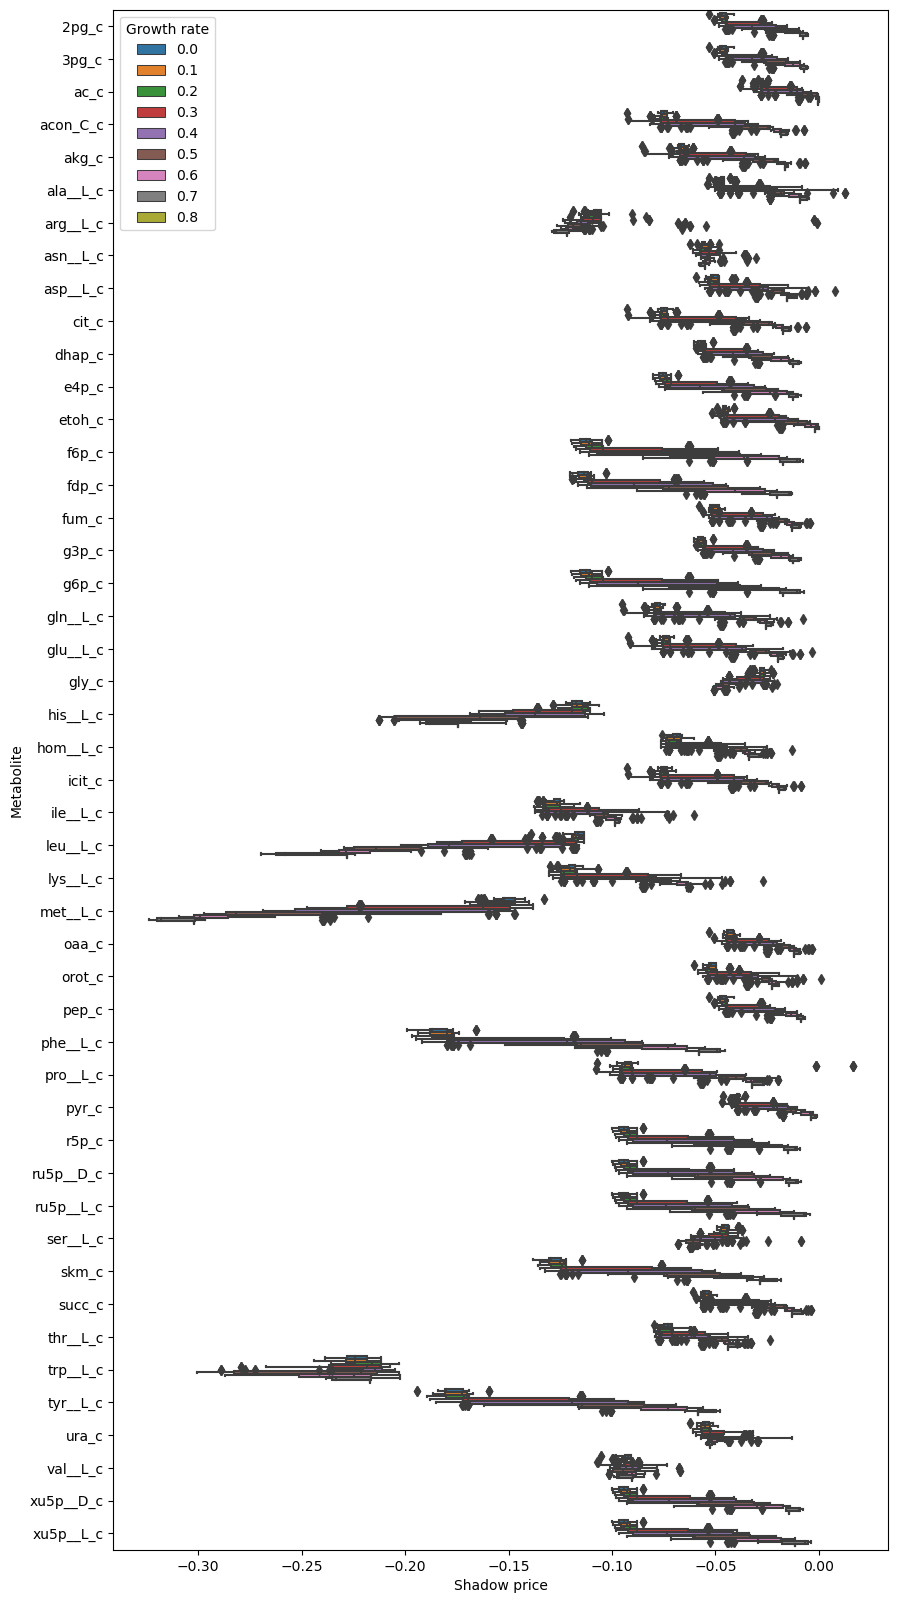

In [20]:
fig, ax = plt.subplots(1,1, figsize = (10,20))
sns.boxplot(data = dfl, x = 'Shadow price', y = 'Metabolite', hue = 'Growth rate')

<AxesSubplot:xlabel='log10(-Shadow price)', ylabel='Metabolite'>

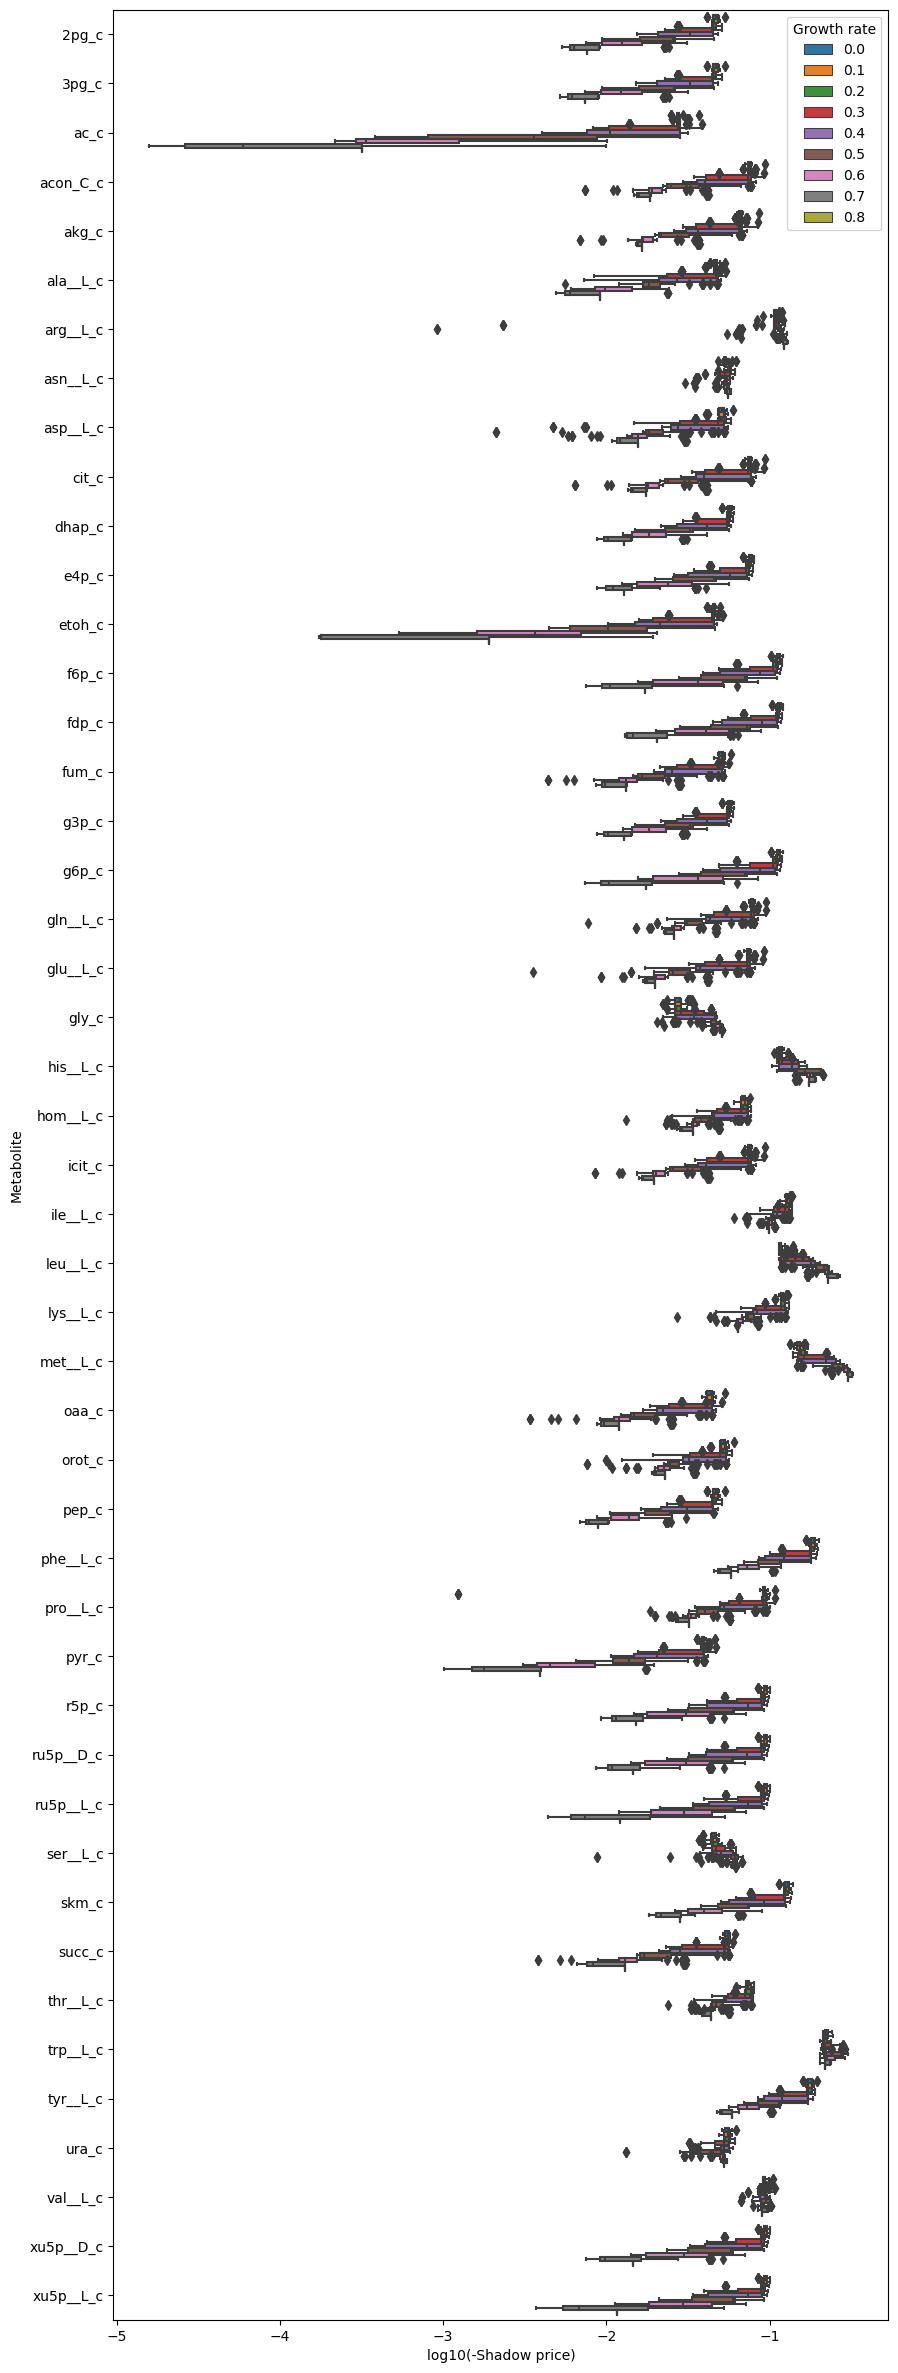

In [21]:
fig, ax = plt.subplots(1,1, figsize = (10,30))
sns.boxplot(data = dfl, x = 'log10(-Shadow price)', y = 'Metabolite', hue = 'Growth rate')

In [22]:
dfl.groupby(['Metabolite','Growth rate']).median().to_csv("../../results/e_coli/median_sp.csv")

In [229]:
dfl.Metabolite.unique()

array(['2pg_c', '3pg_c', 'ac_c', 'acon_C_c', 'akg_c', 'ala__L_c',
       'arg__L_c', 'asn__L_c', 'asp__L_c', 'cit_c', 'dhap_c', 'e4p_c',
       'etoh_c', 'f6p_c', 'fdp_c', 'fum_c', 'g3p_c', 'g6p_c', 'gln__L_c',
       'glu__L_c', 'gly_c', 'his__L_c', 'hom__L_c', 'icit_c', 'ile__L_c',
       'leu__L_c', 'lys__L_c', 'met__L_c', 'oaa_c', 'orot_c', 'pep_c',
       'phe__L_c', 'pro__L_c', 'pyr_c', 'r5p_c', 'ru5p__D_c', 'ru5p__L_c',
       'ser__L_c', 'skm_c', 'succ_c', 'thr__L_c', 'trp__L_c', 'tyr__L_c',
       'ura_c', 'val__L_c', 'xu5p__D_c', 'xu5p__L_c'], dtype=object)

<AxesSubplot:xlabel='Shadow price', ylabel='Metabolite'>

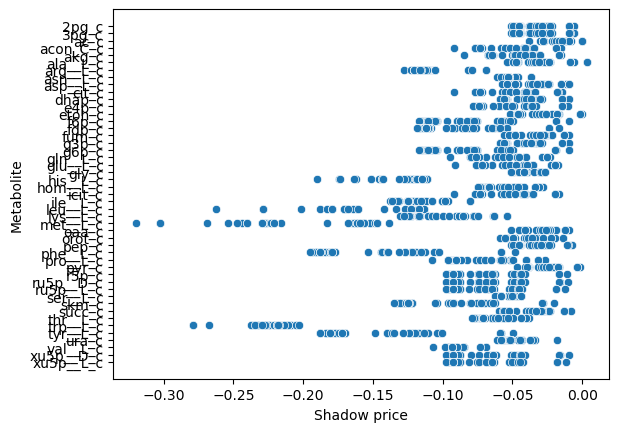

In [126]:
sns.scatterplot(data = dfl.loc[dfl['Uptake rate']=='4',:], x = 'Shadow price', y = 'Metabolite')

<AxesSubplot:xlabel='Shadow price', ylabel='Metabolite'>

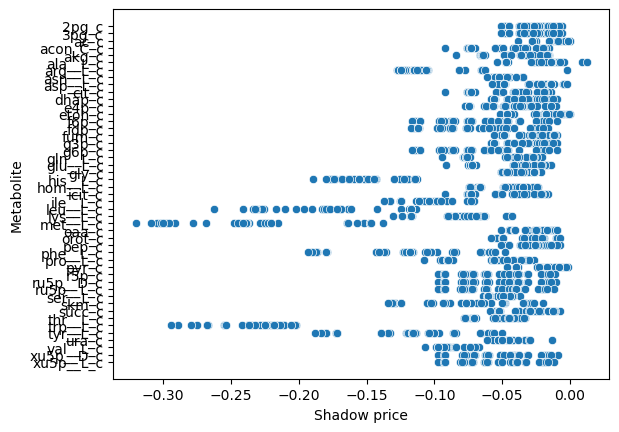

In [131]:
sns.scatterplot(data = dfl.loc[dfl['Uptake rate']=='8',:], x = 'Shadow price', y = 'Metabolite')


In [125]:
dfl['Uptake rate']

0        4
1        8
2       12
3        4
4        8
        ..
5917     8
5918    12
5919     4
5920     8
5921    12
Name: Uptake rate, Length: 5922, dtype: object

In [40]:
dfb.melt()

TypeError: wide_to_long() missing 4 required positional arguments: 'df', 'stubnames', 'i', and 'j'

<AxesSubplot:>

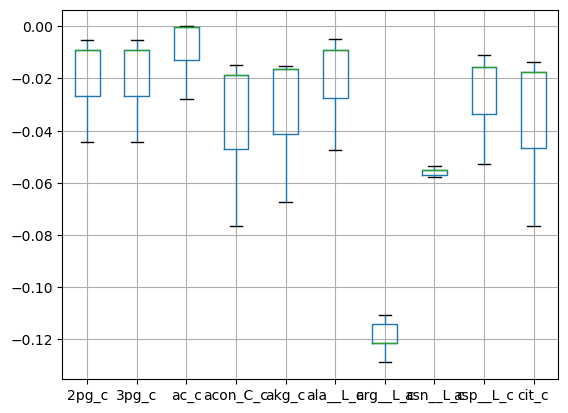

In [39]:
sns.plot(data = dfb, x = )

In [85]:
np.repeat(np.array(glc_uptake_rates)[:,np.newaxis],, axis = 1)

array([[ 4,  4],
       [ 5,  5],
       [ 6,  6],
       [ 7,  7],
       [ 8,  8],
       [ 9,  9],
       [10, 10],
       [11, 11],
       [12, 12],
       [13, 13],
       [14, 14],
       [15, 15]])